In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

['/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/000-000.png',
 '/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/000-001.png',
 '/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/000-002.png',
 '/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/000-003.png',
 '/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/000-004.png',
 '/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/000-005.png',
 '/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/000-006.png',
 '/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/001-000.png',
 '/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/001-001.png',
 '/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/001-002.png',
 '/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/001-003.png',
 '/home/vimalkumar/Documents/images/image tif to jpeg/test/cells/002-000.png',
 '/home/vimalkumar/Documents/images/image tif to jpe

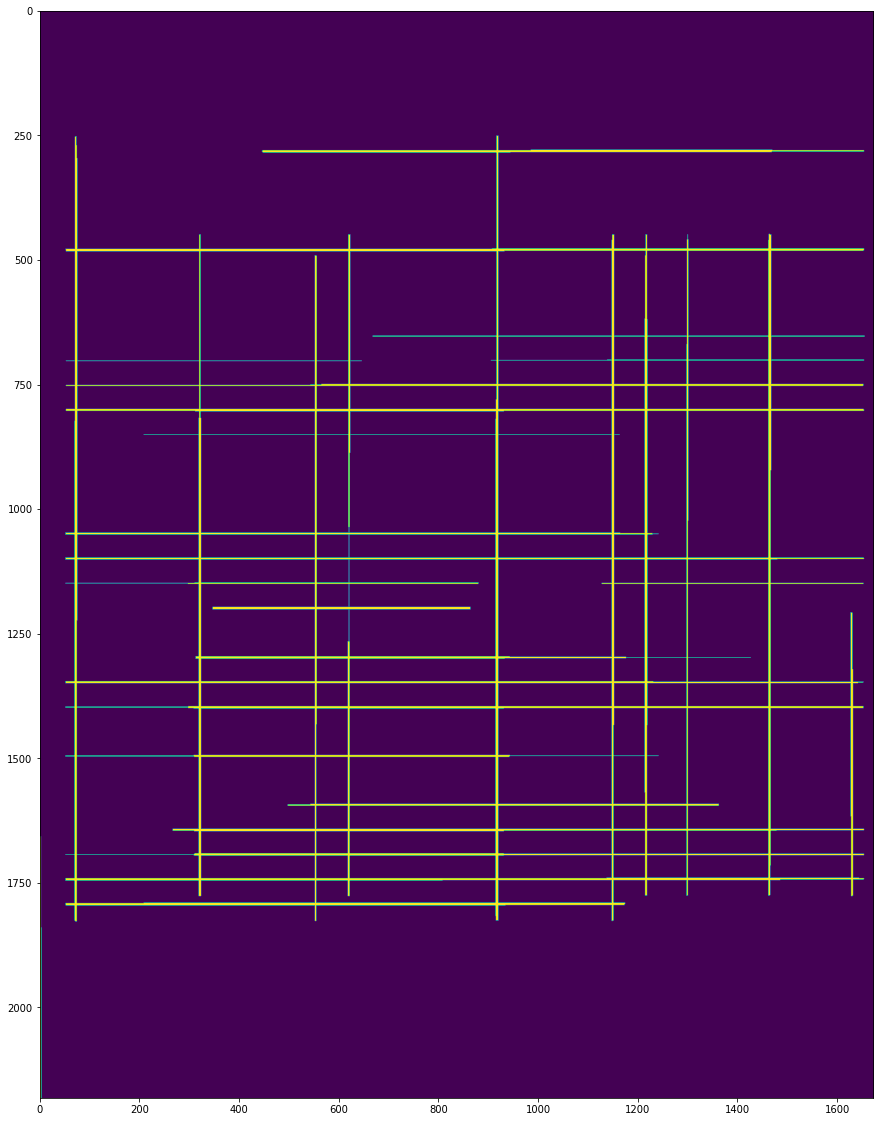

In [12]:
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    from PIL import Image
    #from fuzzywuzzy import fuzz
    #from fuzzywuzzy import process
    import cv2
    import os
    #import math
    import sys
    import numpy as np
    import pytesseract
    import io 
    import csv
    import pandas as pd
    #import shutil, os
    import warnings
    warnings.filterwarnings('ignore')
    def extract_cell_images_from_table(image):
        BLUR_KERNEL_SIZE = (17, 17)
        STD_DEV_X_DIRECTION = 0
        STD_DEV_Y_DIRECTION = 0
        blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
        MAX_COLOR_VAL = 255
        BLOCK_SIZE = 15
        SUBTRACT_FROM_MEAN = -2

        img_bin = cv2.adaptiveThreshold(
            ~blurred,
            MAX_COLOR_VAL,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            BLOCK_SIZE,
            SUBTRACT_FROM_MEAN,
        )
        vertical = horizontal = img_bin.copy()
        SCALE = 5
        image_width, image_height = horizontal.shape
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
        horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
        vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)

        horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
        vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))

        mask = horizontally_dilated + vertically_dilated
        plt.figure(figsize=(20,20))
        plt.imshow(mask)
        jj = Image.fromarray(mask)
        jj.save('/home/vimalkumar/Documents/images/image tif to jpeg/test/table/pg_1_table.jpeg')
        contours, heirarchy = cv2.findContours(
            mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
        )

        perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
        epsilons = [0.05 * p for p in perimeter_lengths]
        approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]

        # Filter out contours that aren't rectangular. Those that aren't rectangular
        # are probably noise.
        approx_rects = [p for p in approx_polys if len(p) == 4]
        bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

        # Filter out rectangles that are too narrow or too short.
        MIN_RECT_WIDTH = 40
        MIN_RECT_HEIGHT = 10
        bounding_rects = [
            r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
        ]

        # The largest bounding rectangle is assumed to be the entire table.
        # Remove it from the list. We don't want to accidentally try to OCR
        # the entire table.
        largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
        bounding_rects = [b for b in bounding_rects if b is not largest_rect]

        cells = [c for c in bounding_rects]
        def cell_in_same_row(c1, c2):
            c1_center = c1[1] + c1[3] - c1[3] / 2
            c2_bottom = c2[1] + c2[3]
            c2_top = c2[1]
            return c2_top < c1_center < c2_bottom

        orig_cells = [c for c in cells]
        rows = []
        while cells:
            first = cells[0]
            rest = cells[1:]
            cells_in_same_row = sorted(
                [
                    c for c in rest
                    if cell_in_same_row(c, first)
                ],
                key=lambda c: c[0]
            )

            row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
            rows.append(row_cells)
            cells = [
                c for c in rest
                if not cell_in_same_row(c, first)
            ]

        # Sort rows by average height of their center.
        def avg_height_of_center(row):
            centers = [y + h - h / 2 for x, y, w, h in row]
            return sum(centers) / len(centers)

        rows.sort(key=avg_height_of_center)
        cell_images_rows = []
        for row in rows:
            cell_images_row = []
            for x, y, w, h in row:
                cell_images_row.append(image[y:y+h, x:x+w])
            cell_images_rows.append(cell_images_row)
        return cell_images_rows

    def main(f):
        results = []
        directory, filename = os.path.split(f)
        table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        rows = extract_cell_images_from_table(table)
        #cell_img_dir = os.path.join(directory, "cells")
        #os.makedirs(cell_img_dir, exist_ok=True)
        out_path = os.path.join('/home/vimalkumar/Documents/images/image tif to jpeg/test/cells')
        paths = []
        for i, row in enumerate(rows):
            for j, cell in enumerate(row):
                cell_filename = "{:03d}-{:03d}.png".format(i, j)
                path = os.path.join(out_path, cell_filename)
                cv2.imwrite(path, cell)
                paths.append(path)
        return paths
    f = '/home/vimalkumar/Documents/images/image tif to jpeg/0569208000_3.tif'
    main(f)

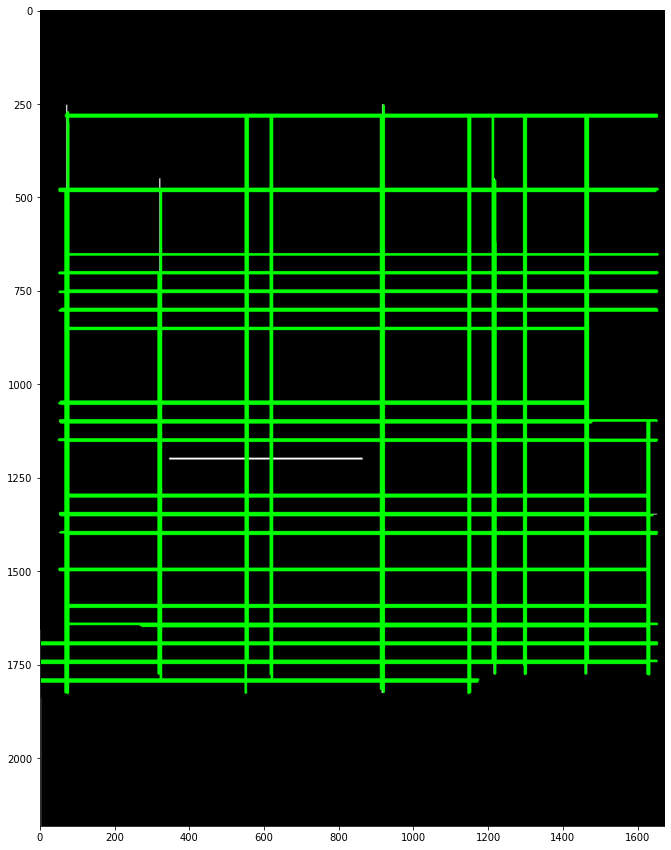

In [13]:
img = cv2.imread('/home/vimalkumar/Documents/images/image tif to jpeg/test/table/pg_1_table.jpeg')
        
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,100,200)
lines = cv2.HoughLinesP(edges,2,np.pi/180,500,maxLineGap = 20000)

for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),5)
    imm = Image.fromarray(img)
    imm.save('/home/vimalkumar/Documents/images/image tif to jpeg/test/table/out/pg_1_table.jpeg')

plt.figure(figsize=(15,15))
plt.imshow(img)